### Student: Bulygin Maksim
### Group: E-1813

In [1]:
from collections import deque
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor, KDTree
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from umap import UMAP

# Explory data analysis (EDA)

## Data reading

Загружаем данные и убеждаемся, что они правильно считались.

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,SalePrice,MSZoning,LotArea,Utilities,Condition1,Condition2,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,Fireplaces,FireplaceQu,GarageArea,GarageQual,GarageCond,PoolArea,PoolQC,Fence,MiscFeature,MiscVal
0,208500,RL,8450,AllPub,Norm,Norm,7,5,2003,2003,...,0,NaN,548,TA,TA,0,NaN,NaN,NaN,0
1,181500,RL,9600,AllPub,Feedr,Norm,6,8,1976,1976,...,1,TA,460,TA,TA,0,NaN,NaN,NaN,0
2,223500,RL,11250,AllPub,Norm,Norm,7,5,2001,2002,...,1,TA,608,TA,TA,0,NaN,NaN,NaN,0
3,140000,RL,9550,AllPub,Norm,Norm,7,5,1915,1970,...,1,Gd,642,TA,TA,0,NaN,NaN,NaN,0
4,250000,RL,14260,AllPub,Norm,Norm,8,5,2000,2000,...,1,TA,836,TA,TA,0,NaN,NaN,NaN,0


In [4]:
df.describe()

,SalePrice,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,PoolArea,MiscVal
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,180921.195890,10516.828082,6.099315,5.575342,1971.267808,1984.865753,1057.429452,1515.463699,2.866438,1.046575,6.517808,0.613014,472.980137,2.758904,43.489041
std,79442.502883,9981.264932,1.382997,1.112799,30.202904,20.645407,438.705324,525.480383,0.815778,0.220338,1.625393,0.644666,213.804841,40.177307,496.123024
min,34900.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,334.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,129975.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,795.750000,1129.500000,2.000000,1.000000,5.000000,0.000000,334.500000,0.000000,0.000000
50%,163000.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,991.500000,1464.000000,3.000000,1.000000,6.000000,1.000000,480.000000,0.000000,0.000000
75%,214000.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,1298.250000,1776.750000,3.000000,1.000000,7.000000,1.000000,576.000000,0.000000,0.000000
max,755000.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,6110.000000,5642.000000,8.000000,3.000000,14.000000,3.000000,1418.000000,738.000000,15500.000000


In [5]:
df.shape

(1460, 37)

## Missing values

Посчитаем долю пропущенных значений по каждому признаку и визуализируем.

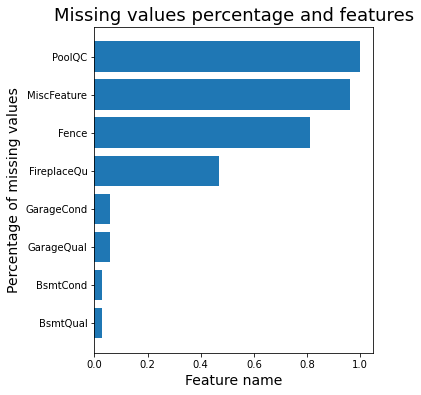

In [6]:
nans_series = (df.isna().sum() / df.shape[0]).round(2).sort_values()
nans_series = nans_series[nans_series != 0]
plt.figure(figsize=(5, 6))
plt.barh(nans_series.index.to_numpy(), nans_series.values)
plt.title('Missing values percentage and features', size=18)
plt.ylabel('Percentage of missing values', size=14)
plt.xlabel('Feature name', size=14)
plt.show();

Признаки _FireplaceQu_, _PoolQC_, _Fence_ и _MiscFeature_ имеют слишком много пропусков, поэтому отбросим их из дальнейшего рассмотрения. А пропуски в остальных заменим модой.

In [7]:
df.drop(
    columns=[
        'FireplaceQu',
        'PoolQC',
        'Fence',
        'MiscFeature',
    ], 
    inplace=True
)

In [8]:
for feature in ['GarageCond', 'GarageQual', 'BsmtCond', 'BsmtQual']:
    df.loc[df[feature].isnull(), feature] = df[feature].mode()[0]

## Numeric and categorical features split

Создадим датафрейм в котором посчитаем количество уникальных значений по каждому признаку.

In [9]:
df_cols = pd.DataFrame(
    data=[(col, df[col].nunique()) for col in df.columns],
    columns=['feature_name', 'num_unique_values']
)
df_cols

,feature_name,num_unique_values
0,SalePrice,663
1,MSZoning,5
2,LotArea,1073
3,Utilities,2
4,Condition1,9
5,Condition2,8
6,OverallQual,10
7,OverallCond,9
8,YearBuilt,112
9,YearRemodAdd,61


Первично для простоты будем считать числовыми признаками те признаки, у которых больше ста уникальных значений, а остальные - категориальными.

In [10]:
df_cols['feature_type'] = df_cols['num_unique_values'].apply(
    lambda x: 'numeric' if x >= 100 else 'categorical'
)

## Outliers detection

Будем искать аномалии в пространтсве признаков, которые посчитали числовыми.

In [11]:
df[df_cols[df_cols['feature_type'] == 'numeric']['feature_name'].tolist()]

,SalePrice,LotArea,YearBuilt,TotalBsmtSF,GrLivArea,GarageArea
0,208500,8450,2003,856,1710,548
1,181500,9600,1976,1262,1262,460
2,223500,11250,2001,920,1786,608
3,140000,9550,1915,756,1717,642
4,250000,14260,2000,1145,2198,836
...,...,...,...,...,...,...
1455,175000,7917,1999,953,1647,460
1456,210000,13175,1978,1542,2073,500
1457,266500,9042,1941,1152,2340,252
1458,142125,9717,1950,1078,1078,240


Воспользуемся двумя алгоритмами поиска аномалий - IsolationForest и LOF.

In [12]:
isol_forest = IsolationForest(random_state=54)
labels_isol_forest = isol_forest.fit_predict(
    df[
        df_cols[df_cols['feature_type'] == 'numeric']['feature_name'].tolist()
    ].values
)
outliers_isol_forest = np.where(labels_isol_forest == -1)[0]

In [13]:
lof = LocalOutlierFactor()
labels_lof = lof.fit_predict(
    df[
        df_cols[df_cols['feature_type'] == 'numeric']['feature_name'].tolist()
    ].values
)
outliers_lof = np.where(labels_lof == -1)[0]

Сравним результаты двух алгоритмов. Можно сказать, что 44 наблюдения точно выбросы, поскольку к выбросам были отнесены сразу двумя алгоритмами, однако посчитаем выбросами все наблюдения, которые были классифицированы выбросами хотя-бы одним из алгоритмов.

In [14]:
tmp_confusion = pd.DataFrame(confusion_matrix(labels_isol_forest, labels_lof))
tmp_confusion.columns = ['lof_outlier', 'lof_not_outlier']
tmp_confusion.index = ['isol_forest_outlier', 'isol_forest_not_outlier']
tmp_confusion

,lof_outlier,lof_not_outlier
isol_forest_outlier,44,103
isol_forest_not_outlier,57,1256


Удалим наблюдения, классифицированные выбросами хотя-бы одним из алгоритмов.

In [15]:
df = df[~(
    (df.index.isin(outliers_isol_forest)) |
    (df.index.isin(outliers_lof))
)].reset_index(drop=True)

## Feature engineering

### Distribution of numeric features

Посмотрим на распределение числовых признаков.

In [16]:
tmp_df = df[df_cols[df_cols['feature_type'] == 'numeric']['feature_name'].tolist()]
df_cols[df_cols['feature_type'] == 'numeric']['feature_name'].tolist()

['SalePrice', 'LotArea', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea', 'GarageArea']

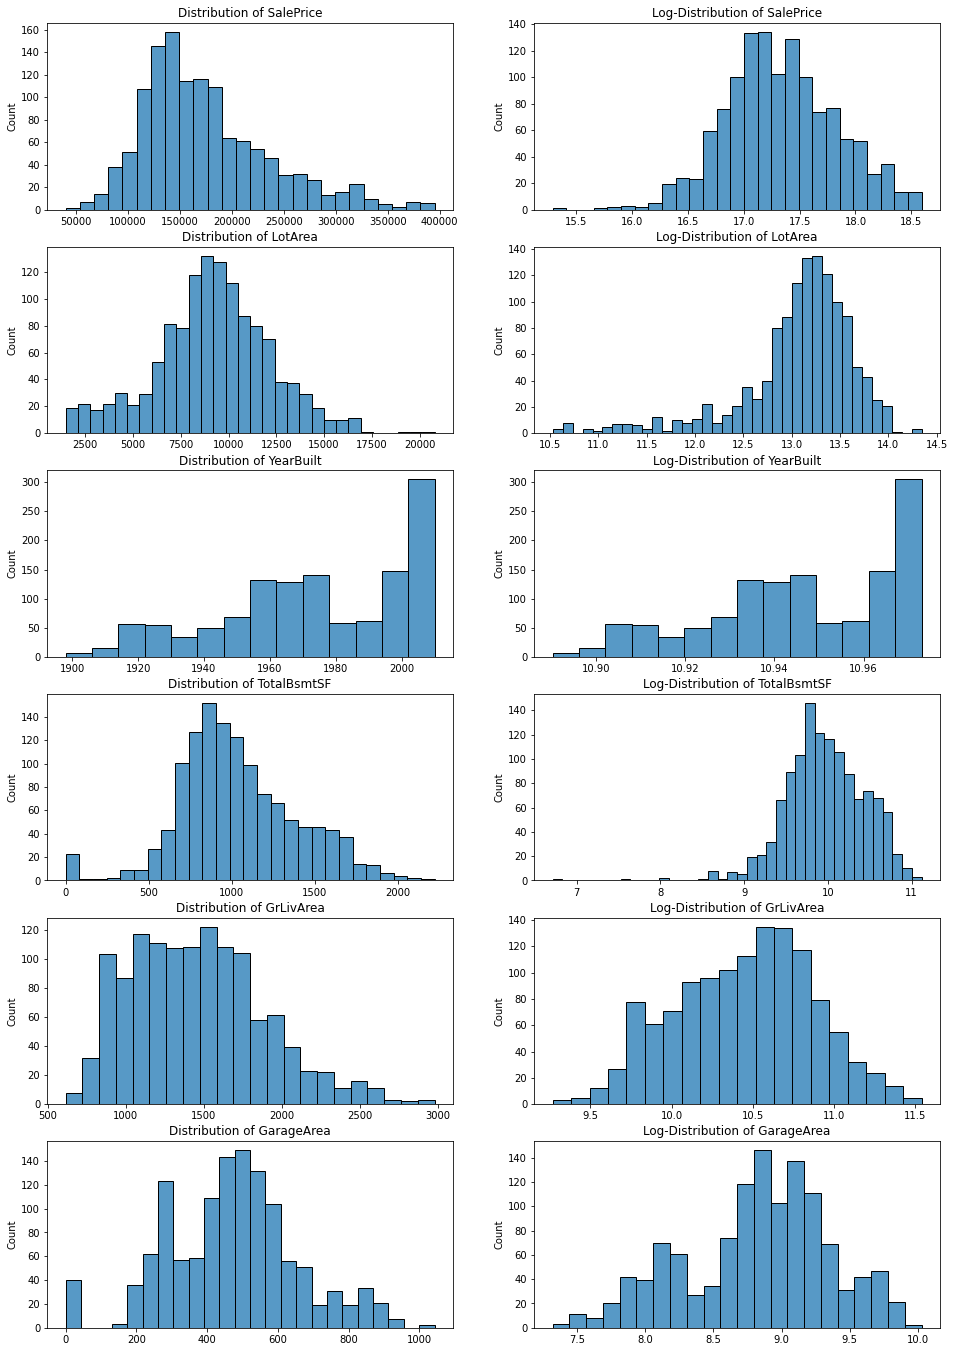

In [17]:
tmp_df = df[df_cols[df_cols['feature_type'] == 'numeric']['feature_name'].tolist()]
fig, axis = plt.subplots(6, 2, figsize=(16, 24))
for i, ax in enumerate(axis.flat):
    if not i % 2:
        ax.set_title(f'Distribution of {tmp_df.columns[i // 2]}')
        sns.histplot(tmp_df.iloc[:, i // 2].values, ax=ax)
    else:
        ax.set_title(f'Log-Distribution of {tmp_df.columns[i // 2]}')
        sns.histplot(np.log2(tmp_df.iloc[:, i // 2].values), ax=ax)

У признака TotalBsmtSF наблюдаются выбросы в левой части хвоста распределения, у признака LotArea наблюдается тяжелый правый хвост, а у признака GarageArea наблюдаются очевидные выбросы в левой части хвоста распределения. Удалим наблюдения, которые попадают в эти хвосты.

In [18]:
df = df[
    (df['LotArea'] <= 17500) &
    (df['TotalBsmtSF'] >= 100) &
    (df['GarageArea'] >= 100)
].reset_index(drop=True)

Распределение числовых признаков после удаления выбросов по распределению.

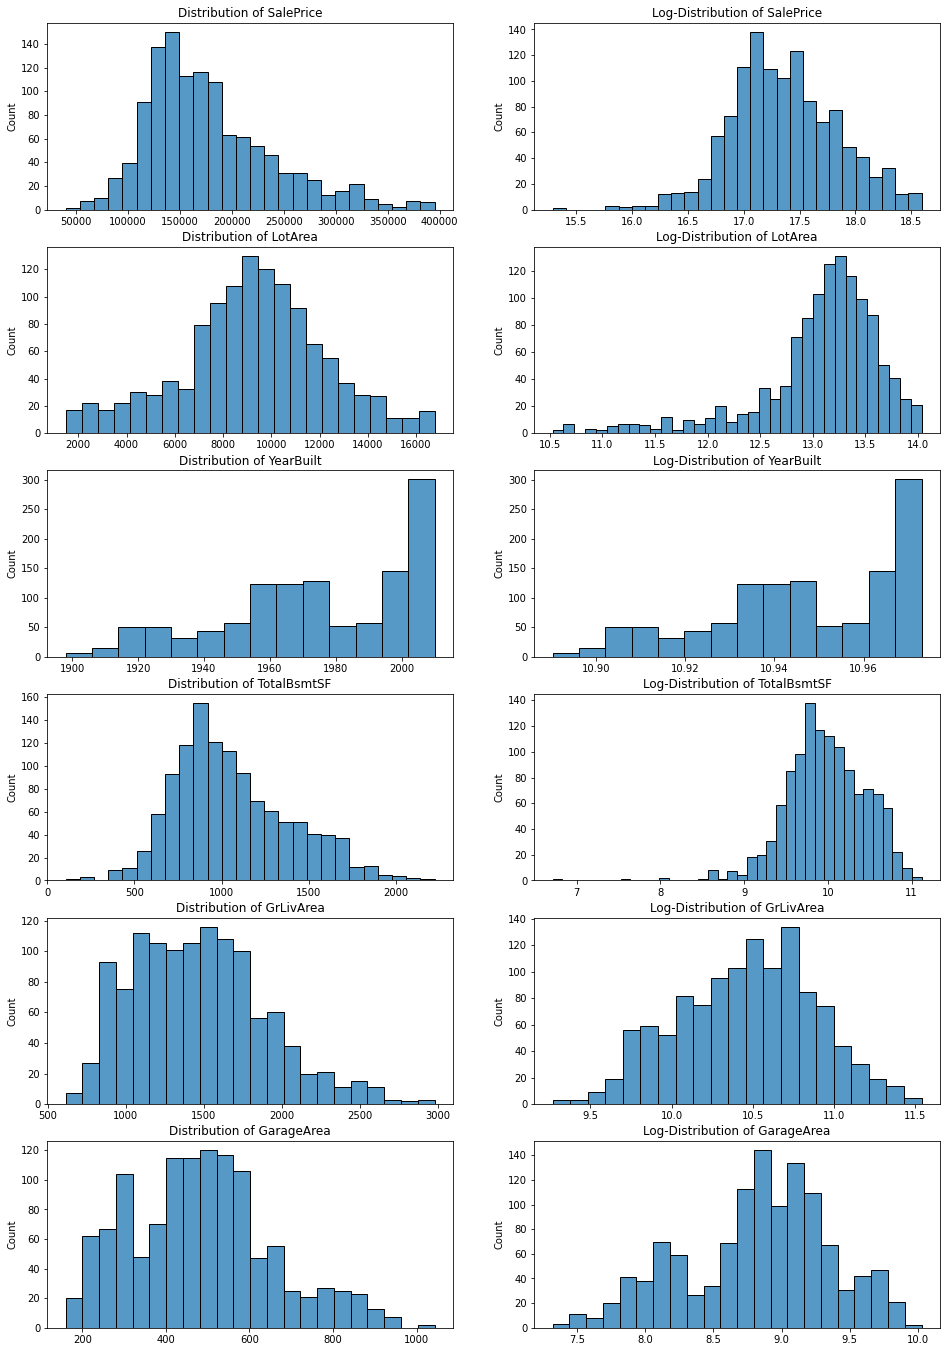

In [19]:
tmp_df = df[df_cols[df_cols['feature_type'] == 'numeric']['feature_name'].tolist()]
fig, axis = plt.subplots(6, 2, figsize=(16, 24))
for i, ax in enumerate(axis.flat):
    if not i % 2:
        ax.set_title(f'Distribution of {tmp_df.columns[i // 2]}')
        sns.histplot(tmp_df.iloc[:, i // 2].values, ax=ax)
    else:
        ax.set_title(f'Log-Distribution of {tmp_df.columns[i // 2]}')
        sns.histplot(np.log2(tmp_df.iloc[:, i // 2].values), ax=ax)

Кластеризовать будем без признака SalePrice, однако интереса ради посмотрим на матрицу попарных корреляций всех числовых признаков.

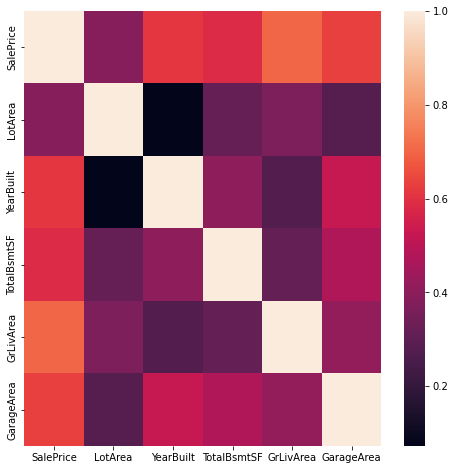

In [20]:
numeric = df_cols[df_cols['feature_type'] == 'numeric']['feature_name'].tolist()
corr = df[numeric].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr)
plt.show();

Все признаки имеют положительную корреляцию с ценой - что логично: чем выше площадь чего-либо/год строительства, тем больше стоит дом.

### Distribution of ordinal and categorical features

Теперь посмотрим на распределения категориальных признаков - на количество уникальных значений каждого признака и относительные частоты этих значений.

In [21]:
for feature in df_cols[df_cols['feature_type'] == 'categorical']['feature_name'].tolist():
    print('=======' * 6)
    print(f'feature {feature} has {df[feature].nunique()} unique values')
    print('relative frequencies of values:')
    print(df[feature].value_counts(normalize=True).round(2).tolist())

feature MSZoning has 5 unique values
relative frequencies of values:
[0.8, 0.14, 0.05, 0.01, 0.01]
feature Utilities has 2 unique values
relative frequencies of values:
[1.0, 0.0]
feature Condition1 has 9 unique values
relative frequencies of values:
[0.88, 0.05, 0.03, 0.02, 0.01, 0.01, 0.0, 0.0, 0.0]
feature Condition2 has 5 unique values
relative frequencies of values:
[0.99, 0.0, 0.0, 0.0, 0.0]
feature OverallQual has 8 unique values
relative frequencies of values:
[0.28, 0.27, 0.24, 0.12, 0.06, 0.03, 0.01, 0.0]
feature OverallCond has 8 unique values
relative frequencies of values:
[0.58, 0.18, 0.14, 0.05, 0.03, 0.01, 0.01, 0.0]
feature YearRemodAdd has 61 unique values
relative frequencies of values:
[0.11, 0.07, 0.06, 0.06, 0.05, 0.04, 0.04, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.

Выведем информацию по тем признакам, у которых частота самого встречающегося значения признака больше 0.85.

In [22]:
for feature in df_cols[df_cols['feature_type'] == 'categorical']['feature_name'].tolist():
    if df[feature].value_counts(normalize=True).round(2).tolist()[0] >= 0.85:
        print('=======' * 6)
        print(f'feature {feature} has {df[feature].nunique()} unique values')
        print('relative frequencies of values:')
        print(df[feature].value_counts(normalize=True).round(2).tolist())

feature Utilities has 2 unique values
relative frequencies of values:
[1.0, 0.0]
feature Condition1 has 9 unique values
relative frequencies of values:
[0.88, 0.05, 0.03, 0.02, 0.01, 0.01, 0.0, 0.0, 0.0]
feature Condition2 has 5 unique values
relative frequencies of values:
[0.99, 0.0, 0.0, 0.0, 0.0]
feature RoofMatl has 5 unique values
relative frequencies of values:
[0.99, 0.0, 0.0, 0.0, 0.0]
feature ExterCond has 4 unique values
relative frequencies of values:
[0.89, 0.1, 0.01, 0.0]
feature BsmtCond has 4 unique values
relative frequencies of values:
[0.93, 0.05, 0.03, 0.0]
feature Heating has 4 unique values
relative frequencies of values:
[0.99, 0.01, 0.0, 0.0]
feature KitchenAbvGr has 3 unique values
relative frequencies of values:
[0.97, 0.02, 0.0]
feature GarageQual has 5 unique values
relative frequencies of values:
[0.95, 0.03, 0.01, 0.0, 0.0]
feature GarageCond has 5 unique values
relative frequencies of values:
[0.96, 0.03, 0.01, 0.01, 0.0]
feature PoolArea has 4 unique val

Видим, что есть много признаков, у которых самое часто встречающееся значение имеет очень высокую частоту - давайте отбросим из рассмотрения такие признаки, потому что они не очень информативные.

In [23]:
features_drop = [
    'Utilities',
    'Condition1',
    'Condition2',
    'RoofMatl',
    'ExterCond',
    'BsmtCond',
    'Heating',
    'KitchenAbvGr',
    'GarageQual',
    'GarageCond',
    'PoolArea',
    'MiscVal'
]

In [24]:
df.drop(columns=features_drop, inplace=True)

Теперь снова посмотрим на распределение признаков после удаления признаков.

In [25]:
for feature in df_cols[df_cols['feature_type'] == 'categorical']['feature_name'].tolist():
    if feature in df.columns.tolist():
        print('=======' * 6)
        print(f'feature {feature} has {df[feature].nunique()} unique values')
        print('relative frequencies of values:')
        print(df[feature].value_counts(normalize=True).round(2).tolist())

feature MSZoning has 5 unique values
relative frequencies of values:
[0.8, 0.14, 0.05, 0.01, 0.01]
feature OverallQual has 8 unique values
relative frequencies of values:
[0.28, 0.27, 0.24, 0.12, 0.06, 0.03, 0.01, 0.0]
feature OverallCond has 8 unique values
relative frequencies of values:
[0.58, 0.18, 0.14, 0.05, 0.03, 0.01, 0.01, 0.0]
feature YearRemodAdd has 61 unique values
relative frequencies of values:
[0.11, 0.07, 0.06, 0.06, 0.05, 0.04, 0.04, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
feature RoofStyle has 5 unique values
relative frequencies of values:
[0.8, 0.19, 0.01, 0.0, 0.0]
feature Exterior1st has 14 unique values
relative frequencies of values:
[0.38, 0.16, 0.16, 0.13, 0.07, 0.04, 0.03, 0.02, 0.01, 0.0

Видим, что есть много значений признаков с частотами < 0.05 - кажется неразумным оставлять их потому, что это дополнительные признаки, которые будут неинформативными (почти весь столбец будет нулей), давайте заменим такие значения на моды по признакам.

In [26]:
for feature in df_cols[df_cols['feature_type'] == 'categorical']['feature_name'].tolist():
    if feature in df.columns.tolist():
        tmp_series = df[feature].value_counts(normalize=True)
        frequencies, feature_values = tmp_series.tolist(), tmp_series.index.tolist()
        for frequency, feature_value in zip(frequencies, feature_values):
            if frequency < 0.05:
                df.loc[df[feature] == feature_value, feature] = feature_values[0] # 0 потому что по 0 индексу максимум относительной частоты встречаемости

Посмотрим, что стало после удаления признаков и замены значений признаков на моды.

In [27]:
for feature in df_cols[df_cols['feature_type'] == 'categorical']['feature_name'].tolist():
    if feature in df.columns.tolist():
        print('=======' * 6)
        print(f'feature {feature} has {df[feature].nunique()} unique values')
        print('relative frequencies of values:')
        print(df[feature].value_counts(normalize=True).round(2).tolist())

feature MSZoning has 3 unique values
relative frequencies of values:
[0.81, 0.14, 0.05]
feature OverallQual has 5 unique values
relative frequencies of values:
[0.31, 0.27, 0.24, 0.12, 0.06]
feature OverallCond has 4 unique values
relative frequencies of values:
[0.64, 0.18, 0.14, 0.05]
feature YearRemodAdd has 4 unique values
relative frequencies of values:
[0.82, 0.07, 0.06, 0.06]
feature RoofStyle has 2 unique values
relative frequencies of values:
[0.81, 0.19]
feature Exterior1st has 5 unique values
relative frequencies of values:
[0.49, 0.16, 0.16, 0.13, 0.07]
feature Exterior2nd has 5 unique values
relative frequencies of values:
[0.49, 0.15, 0.15, 0.12, 0.09]
feature ExterQual has 2 unique values
relative frequencies of values:
[0.63, 0.37]
feature Foundation has 3 unique values
relative frequencies of values:
[0.48, 0.43, 0.09]
feature BsmtQual has 3 unique values
relative frequencies of values:
[0.48, 0.44, 0.07]
feature HeatingQC has 3 unique values
relative frequencies of va

## Feature transforming and encoding

Посмотрим на признак YearRemodAdd - несмотря на то, что это год, у него мало уникальных значений, давайте превратим этот признак в категориальный и потом закодируем OneHot энкодером.

In [28]:
df['YearRemodAdd'].value_counts()

1950    978
2006     78
2007     67
2005     66
Name: YearRemodAdd, dtype: int64

In [29]:
df['YearRemodAdd'] = df['YearRemodAdd'].apply(lambda x: 'OldRemod' if x < 2000 else 'NewRemod')

Категориальные признаки, предполагающие ранжирование - закодируем их как порядковые признаки.

In [30]:
features_ordinal = [
    'ExterQual', 
    'BsmtQual', 
    'HeatingQC', 
    'KitchenQual'
]

order_ordinal_features = {
    'Ex': 5, 
    'Gd': 4, 
    'TA': 3, 
    'Fa': 2, 
    'Po': 1,
    'NA': 0
}

In [31]:
for feature in features_ordinal:
    df[feature] = df[feature].apply(lambda x: order_ordinal_features[x]).astype(int)

In [32]:
df[features_ordinal]

,ExterQual,BsmtQual,HeatingQC,KitchenQual
0,4,4,5,4
1,3,4,5,3
2,4,4,5,4
3,3,3,4,4
4,4,4,5,4
...,...,...,...,...
1184,3,4,5,3
1185,3,4,3,3
1186,3,3,5,4
1187,3,3,4,4


Эти признаки + некоторые другие теперь являются порядковыми которые мы будем кодировать лейбленкодером.

In [33]:
features_label_encoding = [
    'TotRmsAbvGrd',
    'Fireplaces',
    'OverallQual',
    'BedroomAbvGr',
    'OverallCond',
    'ExterQual',
    'BsmtQual', 
    'HeatingQC', 
    'KitchenQual'
]

In [34]:
df[features_label_encoding].head()

,TotRmsAbvGrd,Fireplaces,OverallQual,BedroomAbvGr,OverallCond,ExterQual,BsmtQual,HeatingQC,KitchenQual
0,8,0,7,3,5,4,4,5,4
1,6,1,6,3,8,3,4,5,3
2,6,1,7,3,5,4,4,5,4
3,7,1,7,3,5,3,3,4,4
4,6,1,8,4,5,4,4,5,4


Признаки, которые явлюятся числовыми (убираем SalePrice из рассмотрения).

In [35]:
features_numeric = [
    # 'SalePrice',
    'LotArea',
    'TotalBsmtSF',
    'GrLivArea',
    'GarageArea',
    'YearBuilt'
]

In [36]:
df[features_numeric].head()

,LotArea,TotalBsmtSF,GrLivArea,GarageArea,YearBuilt
0,8450,856,1710,548,2003
1,9600,1262,1262,460,1976
2,11250,920,1786,608,2001
3,9550,756,1717,642,1915
4,14260,1145,2198,836,2000


Признаки, которые будем кодировать OneHot энкодером.

In [37]:
features_onehot_encoding = [
    'MSZoning',
    'RoofStyle',
    'Exterior1st',
    'Exterior2nd', 
    'Foundation',
    'YearRemodAdd'
]

In [38]:
df[features_onehot_encoding].head()

,MSZoning,RoofStyle,Exterior1st,Exterior2nd,Foundation,YearRemodAdd
0,RL,Gable,VinylSd,VinylSd,PConc,OldRemod
1,RL,Gable,MetalSd,MetalSd,CBlock,OldRemod
2,RL,Gable,VinylSd,VinylSd,PConc,OldRemod
3,RL,Gable,Wd Sdng,VinylSd,BrkTil,OldRemod
4,RL,Gable,VinylSd,VinylSd,PConc,OldRemod


Все пространство признаков, которое будем использовать выглядит теперь следующим образом.

In [39]:
df[features_onehot_encoding + features_label_encoding + features_numeric]

,MSZoning,RoofStyle,Exterior1st,Exterior2nd,Foundation,YearRemodAdd,TotRmsAbvGrd,Fireplaces,OverallQual,BedroomAbvGr,OverallCond,ExterQual,BsmtQual,HeatingQC,KitchenQual,LotArea,TotalBsmtSF,GrLivArea,GarageArea,YearBuilt
0,RL,Gable,VinylSd,VinylSd,PConc,OldRemod,8,0,7,3,5,4,4,5,4,8450,856,1710,548,2003
1,RL,Gable,MetalSd,MetalSd,CBlock,OldRemod,6,1,6,3,8,3,4,5,3,9600,1262,1262,460,1976
2,RL,Gable,VinylSd,VinylSd,PConc,OldRemod,6,1,7,3,5,4,4,5,4,11250,920,1786,608,2001
3,RL,Gable,Wd Sdng,VinylSd,BrkTil,OldRemod,7,1,7,3,5,3,3,4,4,9550,756,1717,642,1915
4,RL,Gable,VinylSd,VinylSd,PConc,OldRemod,6,1,8,4,5,4,4,5,4,14260,1145,2198,836,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1184,RL,Gable,VinylSd,VinylSd,PConc,OldRemod,7,1,6,3,5,3,4,5,3,7917,953,1647,460,1999
1185,RL,Gable,Plywood,Plywood,CBlock,OldRemod,7,2,6,3,6,3,4,3,3,13175,1542,2073,500,1978
1186,RL,Gable,VinylSd,VinylSd,PConc,NewRemod,6,2,7,4,5,3,3,5,4,9042,1152,2340,252,1941
1187,RL,Hip,MetalSd,MetalSd,CBlock,OldRemod,5,0,5,2,6,3,3,4,4,9717,1078,1078,240,1950


Закодируем + нормализуем пространство признаков.

In [40]:
steps_ordinal_standard = [
    ('encoder', OrdinalEncoder()),
    ('scaler', StandardScaler())
]

steps_onehot_standard = [
    ('encoder', OneHotEncoder()),
    ('scaler', StandardScaler(with_mean=False))
]

steps_numeric_standard = [
    ('scaler', StandardScaler())
]

transformer_standard = ColumnTransformer([
    ('ordinal_encoding', Pipeline(steps=steps_ordinal_standard), features_label_encoding),
    ('onehot_encoding', Pipeline(steps=steps_onehot_standard), features_onehot_encoding),
    ('numeric_normilizing', Pipeline(steps=steps_numeric_standard), features_numeric)
])
ppln_standard = Pipeline(steps=[('transformer', transformer_standard)])
X_standard = ppln_standard.fit_transform(df.drop(columns=['SalePrice']))

Закодируем + стандартизуем пространство признаков.

In [41]:
steps_ordinal_minmax = [
    ('encoder', OrdinalEncoder()),
    ('scaler', MinMaxScaler())
]

steps_onehot_minmax = [
    ('encoder', OneHotEncoder()),
    # ('scaler', MinMaxScaler())
]

steps_numeric_minmax = [
    ('scaler', MinMaxScaler())
]

transformer_minmax = ColumnTransformer([
    ('ordinal_encoding', Pipeline(steps=steps_ordinal_minmax), features_label_encoding),
    ('onehot_encoding', Pipeline(steps=steps_onehot_minmax), features_onehot_encoding),
    ('numeric_normilizing', Pipeline(steps=steps_numeric_minmax), features_numeric)
])
ppln_minmax = Pipeline(steps=[('transformer', transformer_minmax)])
X_minmax = ppln_minmax.fit_transform(df.drop(columns=['SalePrice']))

# Clustering processes

## Custom DBSCAN implementation

Готовый DBSCAN почему-то отваливался (обучение на стадии .fit(X) не заканчивалось) - не было времени разбираться, поэтому я использовал свою готовую реализацию.

In [42]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        
        
    def fit_predict(self, X, y=None):
        tree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        # метки кластеров, изначально все метки помечены -1, как аномалии
        labels = np.array([-1] * X.shape[0])  
        # список посещенных/не посещенных вершин
        visited = np.array([0] * X.shape[0])  
        clust_num = 0  # номер текущего кластера
        
        for i, row in enumerate(X):
            # если уже просмотрели это наблюдение
            if visited[i]:  
                continue
                
            visited[i] = 1
            # <= m соседей текущего наблюдения включая его
            neighbors = deque(tree.query_radius([row], r=self.eps)[0])  
            
            if len(neighbors) >= self.min_samples:
                while neighbors:  # пока очередь не пуста
                    # индекс текущего рассматриваемого наблюдения
                    ind = neighbors.popleft()  
                    # если наблюдение не посещено - рассматриваем 
                    # его соседей в эпсилон-окрестности
                    if not visited[ind]: 
                        # помечаем наблюдение посещенным
                        visited[ind] = 1  
                        
                        # рассматриваем соседей текущего наблюдения
                        cur_neighbors = tree.query_radius([X[ind]], r=self.eps)[0]  
                        # если количество соседей вершины >= m, то 
                        # добавляем соседей в очередь
                        if len(cur_neighbors) >= self.min_samples:  
                            for el in cur_neighbors:
                                neighbors.append(el)
                    # если текущее наблюдение в -1 кластере, то 
                    # присваиваем ему текущую метку кластера
                    if labels[ind] == -1:  
                        labels[ind] = clust_num
                # после очистки всей очереди увеличиваем номер
                # текущего кластера на единицу
                clust_num += 1  
        return labels

## Clustering with KMeans and DBSCAN at full dimension

### KMeans
#### Finding number of clusters

Для каждого значения кластеров от 2 до 20 и для двух пространств признаков (те что нормализованы и те, что стандартизованы) используем алгоритм KMeans и посчитаем сумму квадратов расстояний от каждой точки до ее ближайшей центроиды и значение метрики качества кластеризации силуэтта.

In [43]:
silhouettes = [[], []]
inertias = [[], []]
cluster_num_begin = 2
cluster_num_end = 20
clustering_range = list(range(cluster_num_begin, cluster_num_end))
for n_clusters in clustering_range:
    for i, X in enumerate([X_standard, X_minmax]):
        kmeans = KMeans(n_clusters=n_clusters, random_state=54).fit(X)
        labels = kmeans.predict(X)
        inertias[i].append(kmeans.inertia_)
        silhouettes[i].append(silhouette_score(X, labels))

Визуализиурем результаты.

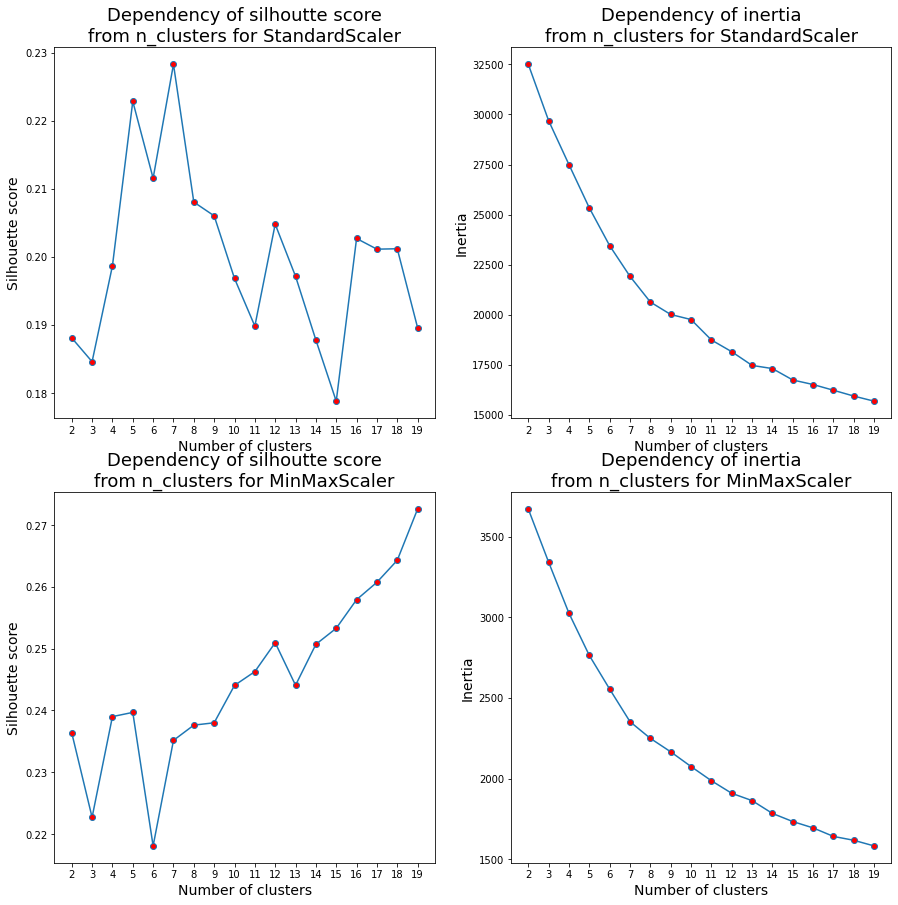

In [44]:
fig, axis = plt.subplots(2, 2, figsize=(15, 15))
for i, scaler in enumerate(['StandardScaler', 'MinMaxScaler']):
    axis[i, 0].plot(
        clustering_range, 
        silhouettes[i],
        marker='o', 
        markerfacecolor='red'
    )
    axis[i, 0].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    axis[i, 0].set_title(
        f'Dependency of silhoutte score\nfrom n_clusters for {scaler}',
        size=18
    )
    axis[i, 0].set_xlabel('Number of clusters', size=14)
    axis[i, 0].set_ylabel('Silhouette score', size=14)

    axis[i, 1].plot(
        clustering_range, 
        inertias[i],
        marker='o', 
        markerfacecolor='red'
    )
    axis[i, 1].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    axis[i, 1].set_title(
        f'Dependency of inertia\nfrom n_clusters for {scaler}', 
        size=18
    )
    axis[i, 1].set_xlabel('Number of clusters', size=14)
    axis[i, 1].set_ylabel('Inertia', size=14)

Метрика качества выше на MinMax скалере - поэтому здесь и далее будем использовать признаковое пространство, полученное именно  MinMax скалером. Оптимальным количеством кластеров по значению силуэтта и сумме квадратов расстояний кажется значение 4 либо 5 (далее выберем 4, потому что результаты более интерпретируемы).

#### KMeans results with 4 clusters

Результаты кластеризации с использованием KMeans и 4 кластерами.

In [45]:
model = KMeans(n_clusters=4, random_state=54)
df['cluster_not_pca_kmeans'] = model.fit_predict(X_minmax)
df[['SalePrice'] + features_numeric + ['cluster_not_pca_kmeans']].groupby(
    'cluster_not_pca_kmeans'
).agg({
    'SalePrice':['count', 'mean', 'median'],
    'YearBuilt':['mean'],
    'GrLivArea':['mean'],
    'LotArea':['mean'],
    'TotalBsmtSF':['mean'],
    'GarageArea':['mean'],
}).T

cluster_not_pca_kmeans              0              1              2  \
SalePrice   count          193.000000     378.000000     436.000000   
            mean        160474.507772  147030.396825  224501.401376   
            median      152000.000000  139925.000000  214000.000000   
YearBuilt   mean          1972.652850    1952.748677    2000.224771   
GrLivArea   mean          1377.259067    1380.126984    1654.846330   
LotArea     mean          9511.036269    9211.148148    9608.172018   
TotalBsmtSF mean          1000.932642     988.841270    1203.293578   
GarageArea  mean           460.761658     415.960317     585.438073   

cluster_not_pca_kmeans              3  
SalePrice   count          182.000000  
            mean        148654.038462  
            median      140000.000000  
YearBuilt   mean          1958.302198  
GrLivArea   mean          1314.307692  
LotArea     mean          8064.505495  
TotalBsmtSF mean           934.164835  
GarageArea  mean           418.972527

### DBSCAN

Результаты кластеризации с использованием DBSCAN - параметры подбирались вручную, исходя из интерпретиации кластеров.

In [46]:
dbs = DBScan(eps=1.5, min_samples=45, metric="euclidean")
df['cluster_not_pca_dbscan'] = dbs.fit_predict(X_minmax)
df[['SalePrice'] + features_numeric + ['cluster_not_pca_dbscan']].groupby(
    'cluster_not_pca_dbscan'
).agg({
    'SalePrice':['count', 'mean', 'median'],
    'YearBuilt':['mean'],
    'GrLivArea':['mean'],
    'LotArea':['mean'],
    'TotalBsmtSF':['mean'],
    'GarageArea':['mean'],
}).T

cluster_not_pca_dbscan             -1              0              1  \
SalePrice   count          485.000000     460.000000     106.000000   
            mean        156328.701031  215122.823913  151358.962264   
            median      144500.000000  207500.000000  148000.000000   
YearBuilt   mean          1957.855670    1995.836957    1969.132075   
GrLivArea   mean          1408.676289    1607.276087    1311.518868   
LotArea     mean          8454.232990    9810.458696    9694.490566   
TotalBsmtSF mean           959.944330    1181.136957    1020.707547   
GarageArea  mean           424.101031     570.900000     457.650943   

cluster_not_pca_dbscan              2              3  
SalePrice   count           79.000000      59.000000  
            mean        136202.544304  167910.949153  
            median      132000.000000  165000.000000  
YearBuilt   mean          1955.784810    1974.406780  
GrLivArea   mean          1264.063291    1470.830508  
LotArea     mean          9207.949367   10274.389831  
TotalBsmtSF mean           925.430380    1210.440678  
GarageArea  mean           396.531646     500.406780

### Visualisation of clustering labels with t-SNE and UMAP

Визуализируем метки кластеров, полученные алгоритмами KMeans и DBSCAN в двумерном признаковом пространстве эмбеддингов с использованием t-SNE и UMAP.

In [47]:
X_embedding_umap = UMAP().fit_transform(X_minmax)
X_embedding_tsne = TSNE(
    n_components=2, 
    learning_rate='auto', 
    init='random'
).fit_transform(X_minmax)

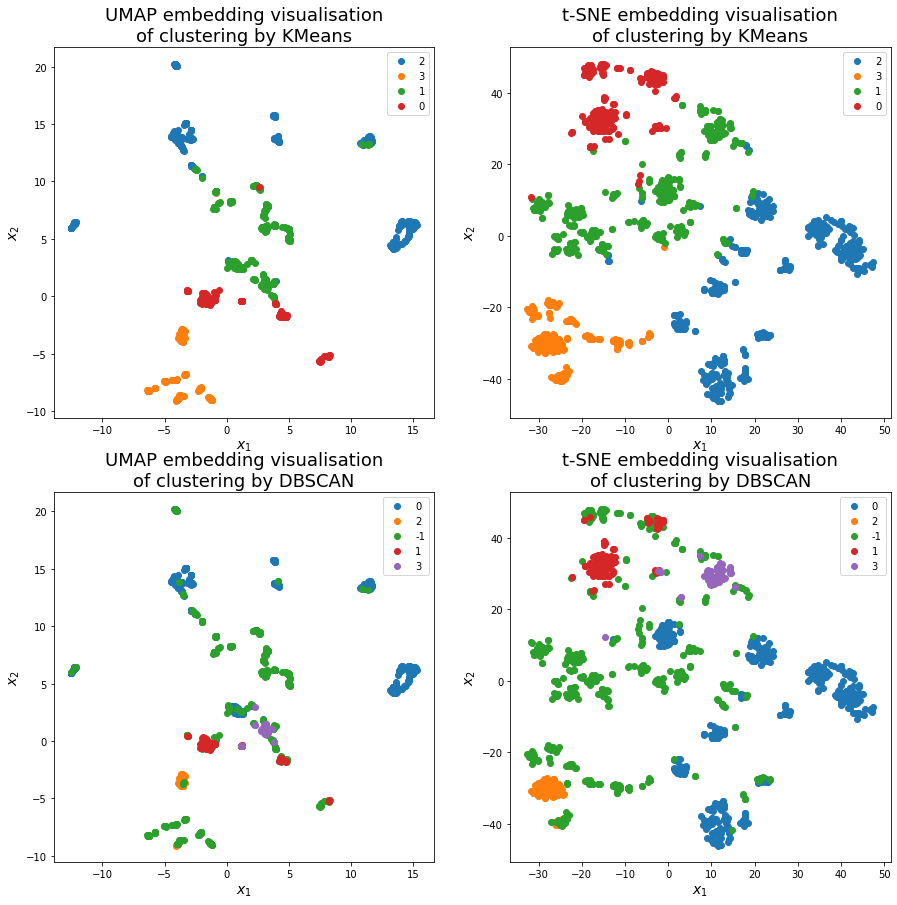

In [48]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, df.cluster_not_pca_kmeans.nunique()))
fig, axis = plt.subplots(2, 2, figsize=(15, 15))
cluster_labels = ['cluster_not_pca_kmeans', 'cluster_not_pca_dbscan']
methods = ['KMeans', 'DBSCAN']
for i in range(2):
    for cluster_number in df[cluster_labels[i]].unique():
        indices = np.where(df[cluster_labels[i]].to_numpy() == cluster_number)[0]
        axis[i, 0].scatter(
            X_embedding_umap[indices][:, 0], 
            X_embedding_umap[indices][:, 1],
            label=f'{cluster_number}'
        )
        axis[i, 1].scatter(
            X_embedding_tsne[indices][:, 0], 
            X_embedding_tsne[indices][:, 1],
            label=f'{cluster_number}'
        )
    axis[i, 0].legend()
    axis[i, 0].set_title(
        f'UMAP embedding visualisation\nof clustering by {methods[i]}',
        size=18
    )
    axis[i, 0].set_xlabel('$x_1$', size=14)
    axis[i, 0].set_ylabel('$x_2$', size=14)
    axis[i, 1].legend()
    axis[i, 1].set_title(
        f't-SNE embedding visualisation\nof clustering by {methods[i]}',
        size=18
    )
    axis[i, 1].set_xlabel('$x_1$', size=14)
    axis[i, 1].set_ylabel('$x_2$', size=14)

Более графически сопоставляемые с результатами кластеризации эмбеддинги получились у t-SNE, а более графически интерпретируемые результаты показывает KMeans - плотные сгустки, тогда как DBSCAN огромную часть наблюдений классфицировал как выбросы (метка -1 и зеленый цвет), не найдя у них достаточное количество соседей в эпсилон-окрестности. 

## Dimension reduction with PCA

Используем PCA для снижения размерности исходного признакового пространства.

In [49]:
pca = PCA()
X_pca = pca.fit_transform(X_minmax)
explained_variance = pca.explained_variance_ratio_.round(3)
cumsum_variance = explained_variance.cumsum()

Остановимся на 10-ти главных компонентах - исходя из разумного числа накопленной доли объясненной дисперсии - 86% и графика накопленной доли объясненной дисперсии.

In [50]:
round(cumsum_variance[10], 2)

0.86

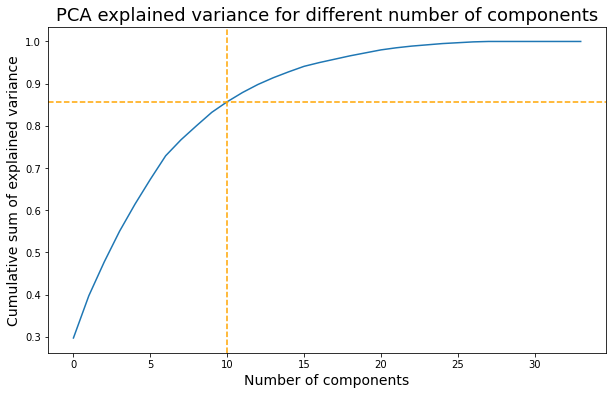

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(cumsum_variance)
plt.title('PCA explained variance for different number of components', size=18)
plt.ylabel('Cumulative sum of explained variance', size=14)
plt.xlabel('Number of components', size=14)
plt.axhline(0.857, ls='--', c = 'orange')
plt.axvline(10, ls='--', c = 'orange')
plt.show();

In [52]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_minmax)
X_pca.shape

(1189, 10)

## Clustering with KMeans and DBSCAN in lower dimension

### KMeans
#### Finding number of clusters

Выполняем те же действия, что и до использования PCA.

In [53]:
silhouette = []
inertia = []
cluster_num_begin = 2
cluster_num_end = 20
clustering_range = list(range(cluster_num_begin, cluster_num_end))
for n_clusters in clustering_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=54).fit(X_pca)
    labels = kmeans.predict(X_pca)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_pca, labels))

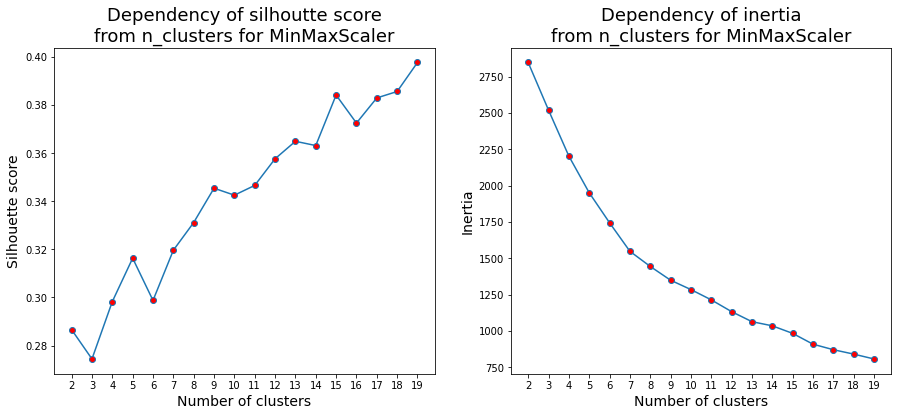

In [54]:
fig, axis = plt.subplots(1, 2, figsize=(15, 6))
axis[0].plot(
    clustering_range, 
    silhouette,
    marker='o', 
    markerfacecolor='red'
)
axis[0].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
axis[0].set_title(
    f'Dependency of silhoutte score\nfrom n_clusters for {scaler}',
    size=18
)
axis[0].set_xlabel('Number of clusters', size=14)
axis[0].set_ylabel('Silhouette score', size=14)

axis[1].plot(
    clustering_range, 
    inertia,
    marker='o', 
    markerfacecolor='red'
)
axis[1].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
axis[1].set_title(
    f'Dependency of inertia\nfrom n_clusters for {scaler}', 
    size=18
)
axis[1].set_xlabel('Number of clusters', size=14)
axis[1].set_ylabel('Inertia', size=14);

#### KMeans results with 4 clusters

In [55]:
model = KMeans(n_clusters=4, random_state=54)
df['cluster_pca_kmeans'] = model.fit_predict(X_pca)
df[['SalePrice'] + features_numeric + ['cluster_pca_kmeans']].groupby(
    'cluster_pca_kmeans'
).agg({
    'SalePrice':['count', 'mean', 'median'],
    'YearBuilt':['mean'],
    'GrLivArea':['mean'],
    'LotArea':['mean'],
    'TotalBsmtSF':['mean'],
    'GarageArea':['mean'],
}).T

cluster_pca_kmeans              0              1              2              3
SalePrice   count      436.000000     182.000000     375.000000     196.000000
            mean    224380.988532  148654.038462  147242.906667  160130.000000
            median  214000.000000  140000.000000  140000.000000  152000.000000
YearBuilt   mean      2000.192661    1958.302198    1952.698667    1972.515306
GrLivArea   mean      1652.596330    1314.307692    1384.570667    1373.806122
LotArea     mean      9598.497706    8064.505495    9222.504000    9506.239796
TotalBsmtSF mean      1202.855505     934.164835     990.288000     998.954082
GarageArea  mean       585.149083     418.972527     416.173333     460.311224

### DBSCAN

Выполняем те же действия, что и до использования PCA.

In [56]:
dbs = DBScan(eps=1.5, min_samples=45, metric="euclidean")
df['cluster_pca_dbscan'] = dbs.fit_predict(X_minmax)
df[['SalePrice'] + features_numeric + ['cluster_pca_dbscan']].groupby(
    'cluster_pca_dbscan'
).agg({
    'SalePrice':['count', 'mean', 'median'],
    'YearBuilt':['mean'],
    'GrLivArea':['mean'],
    'LotArea':['mean'],
    'TotalBsmtSF':['mean'],
    'GarageArea':['mean'],
}).T

cluster_pca_dbscan             -1              0              1  \
SalePrice   count      485.000000     460.000000     106.000000   
            mean    156328.701031  215122.823913  151358.962264   
            median  144500.000000  207500.000000  148000.000000   
YearBuilt   mean      1957.855670    1995.836957    1969.132075   
GrLivArea   mean      1408.676289    1607.276087    1311.518868   
LotArea     mean      8454.232990    9810.458696    9694.490566   
TotalBsmtSF mean       959.944330    1181.136957    1020.707547   
GarageArea  mean       424.101031     570.900000     457.650943   

cluster_pca_dbscan              2              3  
SalePrice   count       79.000000      59.000000  
            mean    136202.544304  167910.949153  
            median  132000.000000  165000.000000  
YearBuilt   mean      1955.784810    1974.406780  
GrLivArea   mean      1264.063291    1470.830508  
LotArea     mean      9207.949367   10274.389831  
TotalBsmtSF mean       925.430380    1210.440678  
GarageArea  mean       396.531646     500.406780

## Clustering results comparison using PCA and without PCA

Сравним результаты кластеризации до использования PCA и после.

In [57]:
# немножко магических констант
labels = {
    0: 3,
    1: 2,
    2: 0,
    3: 1
}

Матрица ошибок меток кластеров с использованием KMeans до и после снижения размерности с PCA. Не сопадают метки кластеров только у пяти наблюдений, бОльшая часть же совпала.

In [58]:
confusion_matrix(
    df['cluster_not_pca_kmeans'].apply(lambda x: labels[x]),
    df['cluster_pca_kmeans']
)

array([[435,   0,   1,   0],
       [  0, 182,   0,   0],
       [  1,   0, 374,   3],
       [  0,   0,   0, 193]])

Матрица ошибок меток кластеров с использованием DBSCAN до и после снижения размерности с PCA. Результаты полностью аналогичные.

In [59]:
confusion_matrix(df['cluster_not_pca_dbscan'], df['cluster_pca_dbscan'])

array([[485,   0,   0,   0,   0],
       [  0, 460,   0,   0,   0],
       [  0,   0, 106,   0,   0],
       [  0,   0,   0,  79,   0],
       [  0,   0,   0,   0,  59]])

_Вывод_: использование PCA позволило снизить размерность признакового пространства в 3 раза, но при этом результаты кластеризации оказались такими же.

## Clustering results interpreting

В качестве финального результата кластеризации, который будем интерпретировать, возьмем метки, полученные алгоритмом KMeans для 4-х кластеров до использования PCA.

In [60]:
# магические константы
cluster_labels = {
    0: 2,
    1: 0,
    2: 3,
    3: 1
}

In [61]:
df['cluster_not_pca_kmeans'] = df['cluster_not_pca_kmeans'].apply(
    lambda x: cluster_labels[x]
)

In [62]:
df[['SalePrice'] + features_numeric + ['cluster_not_pca_kmeans']].groupby(
    'cluster_not_pca_kmeans'
).agg({
    'SalePrice':['count', 'mean', 'median'],
    'YearBuilt':['mean'],
    'GrLivArea':['mean'],
    'LotArea':['mean'],
    'TotalBsmtSF':['mean'],
    'GarageArea':['mean'],
}).T

cluster_not_pca_kmeans              0              1              2  \
SalePrice   count          378.000000     182.000000     193.000000   
            mean        147030.396825  148654.038462  160474.507772   
            median      139925.000000  140000.000000  152000.000000   
YearBuilt   mean          1952.748677    1958.302198    1972.652850   
GrLivArea   mean          1380.126984    1314.307692    1377.259067   
LotArea     mean          9211.148148    8064.505495    9511.036269   
TotalBsmtSF mean           988.841270     934.164835    1000.932642   
GarageArea  mean           415.960317     418.972527     460.761658   

cluster_not_pca_kmeans              3  
SalePrice   count          436.000000  
            mean        224501.401376  
            median      214000.000000  
YearBuilt   mean          2000.224771  
GrLivArea   mean          1654.846330  
LotArea     mean          9608.172018  
TotalBsmtSF mean          1203.293578  
GarageArea  mean           585.438073

_Интерпретация результатов кластеризации_:
- Нулевой кластер - дешевые дома, построенные в среднем в послевоенное десятилетие - то есть очень давнего года строительства, стандартный размер жилой площади, гаража и подавала, но довольно высокая площадь самого участка (LotArea);
- Первый кластер - чуть более дорогие дома, построенные тоже в послевоенное время, из примечательного - низкая площадь самого участка по сравнению с другими кластерами;
- Второй кластер - дома среднего ценового сегмента, постороенные в середине второй половины 20 века, высокие значения всех площадей: подвала, гаража, жилой и участка;
- Третий кластер - новые дома высокого ценового сегмента, современного года строительства, очень высокие значения площади гаража, подвала, жилой площади и площади участка.

## Comparing clustering result labels with the sale price of houses with classification metrics

Сравним результаты кластеризации с результирующим признаком - ценой.

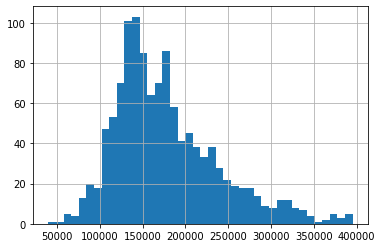

In [63]:
df['SalePrice'].hist(bins=40);

In [64]:
# мода и медиана цены
df['SalePrice'].mean(), df['SalePrice'].median()

(177869.39949537427, 165000.0)

Для каждого дома поймем его статус - дешевый, средний, дорогой и очень дорогой (4 метки, потому что у нас4 кластера).

In [65]:
def transform_prices(price):
    if price <= 129000:
        return 'low_price'
    elif price <= 165000:
        return 'medium_price'
    elif price <= 200000:
        return 'high_price'
    else:
        return 'very_high_price'

In [66]:
prices = {
    'low_price': 0,
    'medium_price': 1,
    'high_price': 2,
    'very_high_price': 3
}

In [67]:
df['property_status'] = df['SalePrice'].apply(lambda x: transform_prices(x))
df['property_classes'] = df['property_status'].apply(lambda x: prices[x])

Матрица ошибок для меток кластеров и статусов домов - выглядит не очень, много трупозитивов и фолснегативов по каждой метке.

In [68]:
confusion_matrix(
    df['property_classes'].values,
    df['cluster_not_pca_kmeans'].values
)

array([[128,  68,  39,   5],
       [154,  73,  76,  55],
       [ 57,  23,  54, 116],
       [ 39,  18,  24, 260]])

Различные метрики классификации - в целом все плохие, кроме тех домов, которые очень дорогие: по ним средний реколл очень высокий - что говорит о том, что бОльшая часть дорогих домов попала в один из кластеров (высокая полнота) и адекватный пресижен (точность).

In [69]:
print(classification_report(
    df['property_classes'].values,
    df['cluster_not_pca_kmeans'].values,
    target_names=list(prices.keys())
))

                 precision    recall  f1-score   support

      low_price       0.34      0.53      0.41       240
   medium_price       0.40      0.20      0.27       358
     high_price       0.28      0.22      0.24       250
very_high_price       0.60      0.76      0.67       341

       accuracy                           0.43      1189
      macro avg       0.40      0.43      0.40      1189
   weighted avg       0.42      0.43      0.41      1189



## Conclusion

В результате выполнения контрольной точкой были выполнены следующие шаги:
1. Были обработаны данные на предмет пропусков и аномалий (выбросов)
2. Было исследовано распределение числовых и категориальных признаков
3. Была совершена предобработка (трансформация нечисловых признаков + стандартизация) данных для последующей кластеризации
4. Была проведена кластеризация на полном пространстве признаков с использованием KMeans и DBSCAN
5. Была проведена кластеризация на сниженном пространстве признаков, полученном с использованием PCA, с использованием KMeans и DBSCAN
6. Было проведено сравнение результатов кластеризации до использования PCA и после
7. Была дана интерпретация полученных кластеров
8. Было проведено сравнение полученных кластеров с метками домов, отранжированных по стоимости, и интерпретированы метрики классификации